In [1]:
from osgeo import gdal

import pandas as pd
import numpy as np
import netCDF4
import h5py
import time 
import xarray
import os
from tqdm import tqdm
import math


def list_in_df(df , KEY , List):
    LIST = []
    for l in List:
        qu = df[ df[ KEY ]   == l ] 
        LIST.append(qu)
    return pd.concat(LIST)

def pixel( file,x,y):
    number_of_col = file.RasterXSize 
    number_of_rows= file.RasterYSize
    left = file.GetGeoTransform()[0]

    top = file.GetGeoTransform()[3]
    res_x = file.GetGeoTransform()[1]
    res_y = file.GetGeoTransform()[5]
    J = int((x-left)/res_x)
    I = int((y-top)/res_y)
    if I>number_of_rows or J>number_of_col or I<0 or J<0 :
        print( "(",I,J ,")" ,"  is out of raster bands" )
    else:
        return I,J

def find_pixel(image_dict,_X,_Y):
    left = image_dict["left"]
    top = image_dict["top"]
    res_x = image_dict["res_x"]
    res_y = image_dict["res_y"]
    c=int(math.floor((_X-left)/res_x))
    r=int(math.floor((_Y-top)/res_y))
    return r,c


def nc_to_pd(nc):
    try:
        Keys = list(nc.keys())
    except:
        Keys = list(nc.variables)
    Panda = {}
    for k in Keys:
        try:
            Panda[k]= np.array(nc[k] )
            PD = pd.DataFrame( Panda )
        except:
            Panda[k] = np.array(nc[k]).T[0]
            PD = pd.DataFrame( Panda )
            pass
    return PD , Panda

def Dict_to_hdf(Dict , of ):
    HDF = h5py.File(of, 'w')
    for k in Dict :    
        test = HDF.create_dataset( k , data = Dict[k] )
    HDF.close()   


c:\Users\S4055367\AppData\Local\anaconda3\envs\Reza2\Lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.3 when it was built against 1.14.2, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [2]:
Folder = "D:/Projects/precipitation_AUS/dataset/0025/"
files = os.listdir(Folder)
hdfs = []

for file in files :
    hdf = h5py.File(Folder + file , 'r+')
    hdfs.append( hdf)
    print(hdf.keys())
    


<KeysViewHDF5 ['CAL_P', 'CAL_P(-1)', 'CAL_P(-2)', 'CAL_P(-3)', 'CAL_P(-4)', 'CAL_P(-5)', 'CAL_P_ave', 'DAY', 'DEWP', 'DEWP_ATTRIBUTES', 'Date', 'ELEVATION', 'ERA5_cape', 'ERA5_cape(-1)', 'ERA5_cape(-2)', 'ERA5_cape(-3)', 'ERA5_cape(-4)', 'ERA5_cape(-5)', 'ERA5_msl', 'ERA5_msl(-1)', 'ERA5_msl(-2)', 'ERA5_msl(-3)', 'ERA5_msl(-4)', 'ERA5_msl(-5)', 'ERA5_t2m', 'ERA5_t2m(-1)', 'ERA5_t2m(-2)', 'ERA5_t2m(-3)', 'ERA5_t2m(-4)', 'ERA5_t2m(-5)', 'ERA5_tcw', 'ERA5_tcw(-1)', 'ERA5_tcw(-2)', 'ERA5_tcw(-3)', 'ERA5_tcw(-4)', 'ERA5_tcw(-5)', 'ERA5_tp', 'ERA5_tp(-1)', 'ERA5_tp(-2)', 'ERA5_tp(-3)', 'ERA5_tp(-4)', 'ERA5_tp(-5)', 'FRSHTT', 'GUST', 'HQ_P', 'HQ_P(-1)', 'HQ_P(-2)', 'HQ_P(-3)', 'HQ_P(-4)', 'HQ_P(-5)', 'LATITUDE', 'LONGITUDE', 'LSTM_RA_0', 'LSTM_RA_0(-1)', 'LSTM_RA_0(-2)', 'LSTM_RA_0(-3)', 'LSTM_RA_0(-4)', 'LSTM_RA_1', 'LSTM_RA_2', 'LSTM_RA_3', 'LSTM_RA_3(-1)', 'LSTM_RA_3(-2)', 'LSTM_RA_3(-3)', 'LSTM_RA_3(-4)', 'LSTM_RA_4', 'LSTM_RA_4(-4)', 'MAX', 'MAX_ATTRIBUTES', 'MIN', 'MIN_ATTRIBUTES', 'MON

In [4]:
needed_keys = [ 'NAME' , 'STATION' , 'LATITUDE' , 'LONGITUDE' ,  
               'YEAR'  , 'MONTH'   ,  'DAY'  , 'PRCP'  
             ] 

DF = {}
for k in needed_keys :
    for hdf in hdfs :
        if (k not in list(DF.keys())) and (k in list(hdf.keys())):
            DF[k] = np.array(hdf[k])
            

In [5]:
df = pd.DataFrame(DF)

### Resamplling GPM IMERG Daily Late run V06
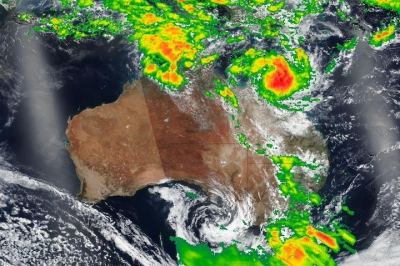 https://gpm.nasa.gov/data/directory/imerg-final-run-pps-research-gis


In [6]:
# IMERG to a dict 
import os

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~INPUTS~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Folder_IMERG = 'D:/DatasetAUS/IMERG-LD6/'

files = os.listdir(Folder_IMERG)

IMERG_dict = {}
band = 'HQprecipitation'  # HQprecipitation  , precipitationCal

for f in tqdm( range( 0 , len(files)), desc="Reading files..." , ncols= 100  ,colour='red'):
    file = files[f]
    try:
        fp =  Folder_IMERG +file 
        nc= netCDF4.Dataset(fp)
        image = np.array(nc[band] )[0]
        IMERG_dict[file] = image
    except: 
        pass

IMERG_dict['lon'] = np.array(nc['lon'] )
IMERG_dict['lat'] = np.array(nc['lat'] )


Reading files...: 100%|█████████████████████████████████████████| 8718/8718 [08:25<00:00, 17.23it/s]


In [7]:
from datetime import datetime as Time
from datetime import timedelta as Delta

In [8]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~INPUTS~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
out_dict={}
lon = IMERG_dict['lon']
lat = IMERG_dict['lat'] 

Folder_output = r"../dataset/"

window_functions = False 
window_extraction = True  
out_window  = {}

for box in [  (13, 13)]:

    for lag in [ 0 , -1 , -2   , -3 , -4 ]:
        WINDOW = [] 

        name_var  = 'HQ_P'  + '(' + str(lag) +  ')'

        # Window extraction  
        
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        r = int((box[0]+1)/2 -1)  # row_delta
        c = int((box[1]+1)/2 -1)  # column_delta

        II  = np.array( [ [i_ for i_ in range(-r , r+1)]  ] * box[0]).T
        JJ  = np.array( [ [j_ for j_ in range(-c , c+1)]  ] * box[1])

        if window_extraction is True :
            LIST_box = [ ]
            for i in range(-r , r+1 , 1):

                for j in range(-c , c+1) :
                    LIST_box.append(name_var + str([i,j]))
            LIST_box.append(name_var + '_Ci' + '_box'+  str(box))
            LIST_box.append(name_var + '_Cj' + '_box'+  str(box))


        BOX_data= []


        t = time.time()

        encoding  =  'utf-8' 
        n = len(df)
        no_value = np.zeros(n)-9999

        out_dict[name_var]  = no_value
                
        def dd(d) :
            if d< 10 :return '0' + str(d)
            else: return  str(d)




        for i in tqdm( range( 0 , n), desc="Sampling..." , ncols= 100  ,colour='blue'):

            # if str(out_dict[name_var][i])  == 'nan'  or   out_dict[name_var][i] == -9999  :

            y , x =  df['LATITUDE'][i]  , df['LONGITUDE'][i] 

            date = Time( int( df['YEAR'][i]  ), int( df['MONTH'][i]  ) ,int(  df['DAY'][i]) ) + Delta(days = lag)

            year , month , day  = str(date.year) , dd(date.month) , dd(date.day)

            
            name_file = '3B-DAY-L.MS.MRG.3IMERG.' + year + month + day + '-S000000-E235959.V06.nc4.nc4'

                
            sq_diff_lat = (lat - y)**2 
            sq_diff_lon = (lon - x)**2
                    
            # Identify the index of the min value for lat and lon
            min_index_lat = sq_diff_lat.argmin()
            min_index_lon = sq_diff_lon.argmin()

            out_dict[name_var][i] =   IMERG_dict[name_file][ min_index_lon  ,  min_index_lat  ] 

            if window_extraction   :

                box_of_values = IMERG_dict[name_file][ min_index_lon - c  :  min_index_lon +c +1 ,  min_index_lat -r : min_index_lat +r +1  ] 
                rotated = np.rot90(box_of_values)
                WINDOW.append(rotated)
                
                # data_of_box = rotated.reshape( box[0]  * box[-1]  )## for all data

                if window_functions : 
                    ave_ = np.mean( rotated )
                    std_ =  np.std( rotated )
                    Ci =  np.sum( rotated * II) / np.sum(rotated)

                    Cj = np.sum( rotated * JJ) / np.sum(rotated)

                    # BOX_data.append( list(data_of_box) + [Ci  , Cj ] ) ## for all data

                    BOX_data.append( [ave_ , std_ , Ci  , Cj ] ) 

            """
            if backup == 5000 :
                
                backup = 0        
                of  =  Folder_output +r"noaa_obs_2014-2024.nc4" + r'_resample-backup-'+str(i)+'.hdf5' 
                Dict_to_hdf(out_dict , of )
            backup += 1 """

        if window_extraction and window_functions :
            BOX_data  = np.array(BOX_data)
            BOX_data = np.nan_to_num(BOX_data , 0) 
            BOX_data = pd.DataFrame( BOX_data  , columns = ['ave' , 'std' , 'Ci' , 'Cj' ])

            BOX_data[name_var + '_ave' + '_box'+  str(box)]  = BOX_data['ave'].values #np.mean(BOX_data , axis = 1 )
            BOX_data[name_var + '_std' + '_box'+  str(box)]  =  BOX_data['std'].values  #np.std(BOX_data , axis = 1 )
            BOX_data[name_var + '_Ci' + '_box'+  str(box)]  =  BOX_data['Ci'].values
            BOX_data[name_var + '_Cj' + '_box'+  str(box)]  =  BOX_data['Cj'].values

        out_window[name_var +'-' +str(box)] = WINDOW 
        '''
    for k in list(BOX_data.keys())[ 4:] :
        out_dict[k]  = np.array( BOX_data[k])

        
    '''
'''
for k in list(BOX_data.keys())[ -4:] :
out_dict[k]  = np.array( BOX_data[k])
'''



Sampling...: 100%|█████████████████████████████████████| 1512035/1512035 [00:48<00:00, 30913.84it/s]


'\nfor k in list(BOX_data.keys())[ -4:] :\nout_dict[k]  = np.array( BOX_data[k])\n'

In [9]:
out_window.keys()

dict_keys(['HQ_P(0)-(13, 13)', 'HQ_P(-1)-(13, 13)', 'HQ_P(-2)-(13, 13)', 'HQ_P(-3)-(13, 13)', 'HQ_P(-4)-(13, 13)'])

In [10]:
DF.shape

AttributeError: 'dict' object has no attribute 'shape'

In [15]:

for k in list(BOX_data.keys())[ 4:] :
    out_dict[k]  = np.array( BOX_data[k])

In [11]:
out_dict

{'CAL_P': array([4.58628273, 4.58628273, 4.70997763, ..., 0.        , 0.        ,
        0.        ]),
 'CAL_P_ave_box(3, 3)': array([9.72671032, 9.72671032, 4.567873  , ..., 0.        , 0.        ,
        0.        ]),
 'CAL_P_std_box(3, 3)': array([7.60569954, 7.60569954, 1.60693145, ..., 0.        , 0.        ,
        0.        ]),
 'CAL_P_Ci_box(3, 3)': array([-0.00559991, -0.00559991,  0.25415664, ...,  0.        ,
         0.        ,  0.        ]),
 'CAL_P_Cj_box(3, 3)': array([-0.54371687, -0.54371687, -0.06389014, ...,  0.        ,
         0.        ,  0.        ]),
 'CAL_P_ave_box(5, 5)': array([10.90667725, 10.90667725,  6.8533659 , ...,  0.07438138,
         0.        ,  0.        ]),
 'CAL_P_std_box(5, 5)': array([9.7363863 , 9.7363863 , 6.53177834, ..., 0.1694307 , 0.        ,
        0.        ]),
 'CAL_P_Ci_box(5, 5)': array([-0.11227513, -0.11227513, -0.05122478, ...,  0.66288984,
         0.        ,  0.        ]),
 'CAL_P_Cj_box(5, 5)': array([-0.93856259, -0.938

In [19]:
Folder

'D:/Projects/precipitation_AUS/dataset/0025/'

In [11]:
# save 

of  = Folder + r"joint-IMERG_hq_Window_13-lags.hdf5"

Dict_to_hdf(out_window , of )

# PDIR
### The Precipitation Estimation from Remotely Sensed Information using Artificial Neural Networks - Dynamic Infrared Rain Rate near real-time
https://chrsdata.eng.uci.edu/

In [6]:
# Read all PDIR 

Folder_PDIR = r'd:\DatasetAUS\PDIR 2013-2024/' #  r'd:\DatasetAUS\PDIR 2013-2024/'

files = os.listdir(Folder_PDIR)
PDIR_dict = {}


for file in files :
    try:
        fp =  Folder_PDIR +file 
        PDIR_image = gdal.Open(fp)
        arr  = PDIR_image.ReadAsArray(0,0,PDIR_image.RasterXSize, PDIR_image.RasterYSize)
        PDIR_dict[file + '_geo'] = PDIR_image
        PDIR_dict[ file] = arr
    except: 
        pass


c:\Users\S4055367\AppData\Local\anaconda3\envs\Reza2\Lib\site-packages\osgeo\gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


In [8]:
out_dict = {}

In [15]:

Folder_output = r"D:/Projects/precipitation_AUS/dataset/"

encoding  =  'utf-8' 
n = len(df)
no_value = np.zeros(n)-9999

window_functions = False 
window_extraction = True  
WINDOW  = [ ]

for box in [  (3, 3) ] :
    for lag in [0]:
        if lag ==0 :name_var = 'PDIR'
        else: name_var = 'PDIR' +  '('+ str(lag) +')'

        # Window extraction  

        window_extraction = True  


        BOX_data  = []

        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

        r = int((box[0]+1)/2 -1)  # row_delta
        c = int((box[1]+1)/2 -1)  # column_delta

        II  = np.array( [ [i_ for i_ in range(-r , r+1)]  ] * box[0]).T
        JJ  = np.array( [ [j_ for j_ in range(-c , c+1)]    ] * box[1])

        if window_extraction is True :
            LIST_box = [ ]
            for i in range(-r , r+1 , 1):

                for j in range(-c , c+1) :
                    LIST_box.append(name_var + str( [i, j  ]))
            LIST_box.append(name_var + '_Ci' + '_box'+  str(box))
            LIST_box.append(name_var + '_Cj' + '_box'+  str(box))


        for k in [name_var]:
            if k  not in df.keys(): out_dict[k]  = no_value
                
        def dd(d) :
            if d< 10 :return '0' + str(d)
            else: return  str(d)

        Date = []
        backup = 0

        for i in tqdm( range( 0 , n), desc="Sampling..." , ncols= 100  ,colour='blue'):
            #if str(out_dict['PDIR'][i])  == 'nan'  or   out_dict['PDIR'][i] == -9999  :
                
            y , x =  df['LATITUDE'][i]  , df['LONGITUDE'][i] 

            date = Time(  int( df['YEAR'][i])  , int(df['MONTH'][i])   ,int( df['DAY'][i]))  + Delta(days = lag)

            year , month , day  = str(date.year) , dd(date.month) , dd(date.day)

            file = 'PDIR_1d' +  year + month + day + '.tif'
            arr  = PDIR_dict[ file]
            ii , jj  = pixel(PDIR_dict[ file + '_geo'],x,y) 


            out_dict[name_var][i] = arr[ii , jj ]
            
            if window_extraction  :

                box_of_values =  arr[ii -r : ii + r +1,  jj- c : jj +c +1   ] 
                WINDOW.append(box_of_values)
                
            # data_of_box = box_of_values.reshape( box[0]  * box[-1]  )
                if window_functions : 
                    ave_ = np.mean( box_of_values )
                    std_ =  np.std( box_of_values )
                    Ci =  np.sum( box_of_values * II) / np.sum(box_of_values)

                    Cj = np.sum( box_of_values * JJ) / np.sum(box_of_values)

                    # BOX_data.append( list(data_of_box) + [Ci  , Cj ] ) ## for all data

                    BOX_data.append( [ave_ , std_ , Ci  , Cj ] ) 

        
        if window_extraction and  window_functions :
            BOX_data  = np.array(BOX_data)
            BOX_data = np.nan_to_num(BOX_data , 0) 
            BOX_data = pd.DataFrame( BOX_data  , columns = ['ave' , 'std' , 'Ci' , 'Cj' ])

            BOX_data[name_var + '_ave' + '_box'+  str(box)]  = BOX_data['ave'].values #np.mean(BOX_data , axis = 1 )
            BOX_data[name_var + '_std' + '_box'+  str(box)]  =  BOX_data['std'].values  #np.std(BOX_data , axis = 1 )
            BOX_data[name_var + '_Ci' + '_box'+  str(box)]  =  BOX_data['Ci'].values
            BOX_data[name_var + '_Cj' + '_box'+  str(box)]  =  BOX_data['Cj'].values


    if window_extraction and  window_functions : # write in the out_dict
        for k in list(BOX_data.keys())[ 4:] :
            out_dict[k]  = np.array( BOX_data[k])

out_window = { 'PDIR_3' : WINDOW }
       

Sampling...:   0%|                                                      | 0/1512035 [00:00<?, ?it/s]

Sampling...: 100%|█████████████████████████████████████| 1512035/1512035 [00:32<00:00, 46226.04it/s]


In [20]:
BOX_data.keys()

Index(['ave', 'std', 'Ci', 'Cj', 'PDIR_ave_box(7, 7)', 'PDIR_std_box(7, 7)',
       'PDIR_Ci_box(7, 7)', 'PDIR_Cj_box(7, 7)'],
      dtype='object')

In [10]:
out_window

{'PDIR_7': [array([[3, 4, 4, 2, 4, 5, 5],
         [2, 2, 3, 3, 4, 5, 5],
         [2, 3, 2, 3, 4, 6, 5],
         [1, 2, 1, 2, 1, 2, 1],
         [1, 2, 1, 1, 1, 1, 1],
         [1, 2, 1, 1, 1, 1, 1],
         [1, 1, 2, 1, 1, 1, 2]], dtype=int16),
  array([[0, 1, 1, 1, 0, 1, 1],
         [0, 0, 0, 0, 1, 1, 1],
         [0, 0, 0, 0, 1, 1, 1],
         [1, 1, 1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1, 1, 1]], dtype=int16),
  array([[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0]], dtype=int16),
  array([[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0]], dtype=int16),
  array([[0, 0, 0, 0, 0, 0, 0],
  

In [16]:

of  = r"D:/Projects/precipitation_AUS/dataset/0025/joint_PDIR_WINDOW_3.hdf5"
Dict_to_hdf(out_window , of )

In [12]:

# ERA5 Read files 


def ERA_Folder_to_dict(Folder_ERA5): 

    files = os.listdir(Folder_ERA5)
    ERA5_dict = {}
    for file in files :
        fp = Folder_ERA5 + file 
        hdf = h5py.File( fp  )
        Lk = list(hdf.keys())

        for k in Lk:
            ERA5_dict[k]  = np.array(hdf[k])
        hdf.close()
    return ERA5_dict 

out_dict = { }

window_functions = False 
window_extraction = True  

# out_window  = { }

for box in [    (5, 5 )]:
    
    for lag in  [0]:
            
        for variable in [  'tcw' ] : # 'tp', 't2m' , 'cape'  , 'tcw'
            print(  variable , lag  , box)
            
            out_window[variable +'_' +str(box[0]) ]  = []
            if lag == 0 :
                name_var = 'ERA5_' + variable 
            else :
                name_var = 'ERA5_' + variable  +  '('+ str(lag) +')'

            Folder_ERA5_  = r"d:\DatasetAUS\ERA5/"+variable+'/'

            

            
            ERA5_dict = ERA_Folder_to_dict(Folder_ERA5_)

            encoding  =  'utf-8' 
            n = len(df)
            no_value = np.zeros(n)-9999

            


            # Window extraction  

            window_extraction = True  

            
            BOX_data  =[]
            # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~



            r = int((box[0]+1)/2 -1)  # row_delta
            c = int((box[1]+1)/2 -1)  # column_delta

            II  = np.array( [ [i_ for i_ in range(-r , r+1)]  ] * box[0]).T
            JJ  = np.array( [ [j_ for j_ in range(-c , c+1)]    ] * box[1])

            if window_extraction is True :
                LIST_box = [ ]
                for i in range(-r , r+1 , 1):

                    for j in range(-c , c+1) :
                        LIST_box.append(name_var + str( [i,j]))
                LIST_box.append(name_var + '_Ci'  + '_box'+  str(box) )
                LIST_box.append(name_var + '_Cj'  + '_box'+  str(box))

            out_dict[name_var]  = no_value
                    
            def dd(d) :
                if d< 10 :return '0' + str(d)
                else: return  str(d)

            Date = []
            backup = 0

            for i in tqdm( range( 0 , n), desc="Sampling..." , ncols= 100  ,colour='blue'):

                #if str(out_dict['PDIR'][i])  == 'nan'  or   out_dict['PDIR'][i] == -9999  :
                    
                y , x =  df['LATITUDE'][i]  , df['LONGITUDE'][i] 

                date = Time(int( df['YEAR'][i] ) , int( df['MONTH'][i]   ) , int( df['DAY'][i]))   + Delta(days = lag)

                year , month , day  = str(date.year) , dd(date.month) , dd(date.day)

                name_file =  year + '-' + month +'-'+ day 
                
                    
                sq_diff_lat = (ERA5_dict['lat'] - y)**2 
                sq_diff_lon = (ERA5_dict['lon'] - x)**2
                        
                # Identify the index of the min value for lat and lon
                min_index_lat = sq_diff_lat.argmin()
                min_index_lon = sq_diff_lon.argmin()

                out_dict[name_var][i] =   ERA5_dict[name_file][ min_index_lat  ,  min_index_lon  ] 

                if window_extraction is True :
                    box_of_values = ERA5_dict[name_file][ min_index_lat - c  :  min_index_lat +c +1 ,  min_index_lon -r : min_index_lon +r +1  ] 

                    if variable  in ['cape'  ,'tp' , 'tcw'] : box_of_values = np.maximum(box_of_values  , 0 )
                    out_window[variable +'_' +str(box[0]) ].append(box_of_values)

                    if window_functions : 

                        ave_ = np.mean( box_of_values )
                        std_ =  np.std( box_of_values )
                        Ci =  np.sum( box_of_values * II) / np.sum(box_of_values)

                        Cj = np.sum( box_of_values * JJ) / np.sum(box_of_values)

                    # BOX_data.append( list(data_of_box) + [Ci  , Cj ] ) ## for all data

                        BOX_data.append( [ave_ , std_ , Ci  , Cj ] ) 
            
            if window_extraction and window_functions  :
                BOX_data  = np.array(BOX_data)
                BOX_data = np.nan_to_num(BOX_data , 0) 
                

                BOX_data = pd.DataFrame( BOX_data  , columns = ['ave' , 'std' , 'Ci' , 'Cj' ])

                BOX_data[name_var + '_ave' + '_box'+  str(box)]  = BOX_data['ave'].values #np.mean(BOX_data , axis = 1 )
                BOX_data[name_var + '_std' + '_box'+  str(box)]  =  BOX_data['std'].values  #np.std(BOX_data , axis = 1 )
                BOX_data[name_var + '_Ci' + '_box'+  str(box)]  =  BOX_data['Ci'].values
                BOX_data[name_var + '_Cj' + '_box'+  str(box)]  =  BOX_data['Cj'].values
            if window_extraction and window_functions  :
                for k in  list(BOX_data.keys())[ -4:] :
                    out_dict[k]  = np.array( BOX_data[k])



'''
if  Path( of ).suffix  in  ['.nc4' , '.nc'  ] :
    df_out = pd.DataFrame(out_dict)
    del df_out['dim_0']
    xr = xarray.Dataset(df_out)
    xr.to_netcdf(of , format = 'NETCDF4' ) 
elif Path( of ).suffix  in  ['.hdf' , '.hdf5'  ]:
    Dict_to_hdf(out_dict , of )
'''




tcw 0 (5, 5)


Sampling...: 100%|█████████████████████████████████████| 1512035/1512035 [01:31<00:00, 16612.26it/s]


"\nif  Path( of ).suffix  in  ['.nc4' , '.nc'  ] :\n    df_out = pd.DataFrame(out_dict)\n    del df_out['dim_0']\n    xr = xarray.Dataset(df_out)\n    xr.to_netcdf(of , format = 'NETCDF4' ) \nelif Path( of ).suffix  in  ['.hdf' , '.hdf5'  ]:\n    Dict_to_hdf(out_dict , of )\n"

In [13]:
out_window.keys()

dict_keys(['tp_3', 't2m_3', 'cape_3', 'tcw_3', 'tp_5', 't2m_5', 'cape_5', 'tp_7', 't2m_7', 'cape_7', 'tcw_7', 'tcw_5'])

In [15]:
Dict_to_hdf(out_window , r'D:/Projects/precipitation_AUS/dataset/0025/' +  r"joint-ERA5_WINDOW.hdf5"  )

# To exclude stations with less than 'Ns' data

In [7]:
# To exclude stations with less than 'Ns' data 
Ns = 100
ex_stations = pd.read_excel(r'D:\Projects\precipitation_AUS\stations_noaa_in_dataset.xlsx' )
ex = ex_stations[ ex_stations['number_of_data'] > Ns ]
encoding  =  'utf-8'
stations = np.array(ex['STATION']) 
DF = list_in_df(df , 'STATION' , stations)
xr = xarray.Dataset(DF)
xr.to_netcdf( "../dataset/noaa_obs_2014-2024.nc4" + r'_resample-0002.nc4' ,
             format = 'NETCDF4'  )

In [191]:
def task( I ):
    encoding  =  'utf-8' 
    n = len(df)
    no_value = np.zeros(n)-9999

    out_dict = {   }

    for k in ['HQ_P' ,  'CAL_P'  , 'Date' ]:
        if k  in df.keys():
            out_dict[k]  = df[k]
        else:
            out_dict[k]  = no_value

    for i in range(  I[0] ,  I[1]) : #tqdm(range(  I[0] ,  I[1]), desc="Sampling..." , ncols= 100  ,colour='blue'):
        if str(out_dict['CAL_P'][i])  == 'nan'  or   out_dict['CAL_P'][i] == -9999  : 
            y , x =  df['LATITUDE'][i]  , df['LONGITUDE'][i] 
            date = str(df['DATE'][i] , encoding) 

            year , month , day  = date[:4]   , date[5:7]  , date[8:10] 

            fp = 'd:/DatasetAUS/IMERG-LD6/3B-DAY-L.MS.MRG.3IMERG.' + year + month + day + '-S000000-E235959.V06.nc4.nc4'

            nc = netCDF4.Dataset(fp)

            lon = np.array(nc['lon'] )
            lat = np.array(nc['lat'] )
            hq_p = np.array(nc['HQprecipitation'] )[0]
            cal_p = np.array(nc['precipitationCal'] )[0]
            
            sq_diff_lat = (lat - y)**2 
            sq_diff_lon = (lon - x)**2
                    
            # Identify the index of the min value for lat and lon
            min_index_lat = sq_diff_lat.argmin()
            min_index_lon = sq_diff_lon.argmin()


            out_dict['HQ_P'][i] = hq_p[   min_index_lon  , min_index_lat   ] 
            out_dict['CAL_P'][i] =  cal_p[ min_index_lon  ,  min_index_lat  ] 
            
            out_dict['Date'][i]  =   date
        
    return out_dict

    

In [16]:
import concurrent.futures
import time
t = time.time()

with concurrent.futures.ThreadPoolExecutor() as executor:
    # Submit tasks to the executor
    futures = [executor.submit(task, mem ) for mem in [   (0 , 1000)   , (1000  , 2000)  , (2000 , 3000)  ]]
    # Collect the results
    results = [future.result() for future in concurrent.futures.as_completed(futures)]

print(time.time() - t)


23.970303773880005


In [192]:
List = [  ( i*1000 , (i+1)*1000 ) for i in range(int(n/1000)) ] 
import time
from joblib import Parallel, delayed


In [193]:
import xarray  
List.append(  (List[-1][1]  , n  )) 
nn = len(List)
t = time.time()
all_result = [ ]

step = 3 
backup = 0 

for i in tqdm( range( 0 , int( nn / step) +1 ), desc="Sampling..." , ncols= 100  ,colour='blue'):

    result = Parallel(n_jobs=60)(delayed(task)(mem) for mem in List[ i*step : (i+1) * step] )
    #print(result)
    #print(time.time() - t)

    for DF in result :
        df_result = pd.DataFrame(DF)
        all_result.append(df_result)
    
    if backup == 30 :
        result_out = pd.concat( all_result , axis = 0  , ignore_index=True )
        df_out = pd.concat( [df , result_out ]  , axis = 1  )
        del df_out['dim_0']
        xr_out = xarray.Dataset(df_out)
        xr_out.to_netcdf( r"D:\Projects\precipitation_AUS\dataset\noaa_obs_2014-2024.nc4" + '_resample-backup-'+str(i)+'.nc4'  , format = 'netCDF4' )
        backup = 0 
    backup += 1 

print(time.time() - t)

result_out = pd.concat( all_result , axis = 0  , ignore_index=True )
df_out = pd.concat( [df , result_out ]  , axis = 1  )
del df_out['dim_0']
xr_out = xarray.Dataset(df_out)
xr_out.to_netcdf( r"D:\Projects\precipitation_AUS\dataset\noaa_obs_2014-2024.nc4" + '_resample.nc4'  , format = 'netCDF4' )


Sampling...:   5%|██▍                                            | 30/565 [03:40<1:05:27,  7.34s/it]


MemoryError: Unable to allocate 10.6 GiB for an array with shape (9, 157518750) and data type float64

In [194]:
result_out 

,HQ_P,CAL_P,Date
0,5.755,42.075459,b'2014-01-01'
1,0.050,0.137634,b'2014-01-02'
2,0.000,0.000000,b'2014-01-03'
3,0.000,0.729596,b'2014-01-04'
4,0.000,0.000000,b'2014-01-05'
...,...,...,...
157518745,NaN,NaN,b''
157518746,NaN,NaN,b''
157518747,NaN,NaN,b''
157518748,NaN,NaN,b''


In [83]:
result_out = pd.concat( all_result , axis = 0  , ignore_index=True )
df_out = pd.concat( [df , result_out ]  , axis = 1  )
xr_out = xarray.Dataset(df_out)

xr_out.to_netcdf( r"D:\Projects\precipitation_AUS\dataset\noaa_obs_2014-2024.nc4" + '_resample-backup.nc4'  , format = 'netCDF4' )

In [97]:
df_out.to_excel( r"D:\Projects\precipitation_AUS\dataset\noaa_obs_2014-2024.nc4" + '_resample-backup.xlsx'  )

ValueError: This sheet is too large! Your sheet size is: 1693750, 34 Max sheet size is: 1048576, 16384